# a demo for vit in timm

## 1st Step
- create model and load pretrained weight
- load labels

In [1]:
import torch
from torch import nn
from torchvision import transforms
import json
from PIL import Image
from timm.models.vision_transformer import vit_small_patch14_dinov2

from json_dump_util import json_dumps_print


# dinov2 vit
model = vit_small_patch14_dinov2(pretrained=True)

# Set model to eval mode for inference
model.eval()

# imagenet labels
with open('in1k_id2label.json', 'r') as f:
    id2label = json.load(f)
labels = [v for k, v in id2label.items()]

# model parameters
patch_size = 14
nhead = 6
image_size = 518

image_path = 'dog.jpg'

print("attention num_heads:", nhead)
print("patch_size:", patch_size)
print("model.patch_embed.num_patches:", model.patch_embed.num_patches)
print("model.embed_dim:", model.embed_dim)
print("model.num_classes:", model.num_classes)

attention num_heads: 6
patch_size: 14
model.patch_embed.num_patches: 1369
model.embed_dim: 384
model.num_classes: 0


## 2nd Step
- create transform for image

In [2]:
# Create Transform
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229,0.224,0.225]
    # )
])

print(transform)

Compose(
    Resize(size=(518, 518), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


# 3rd Step
- input image to model
- show result

In [3]:
@torch.no_grad()
def forward_test(img_name, transform, top_k=5):
    img = Image.open(img_name)

    # Process PIL image with transforms and add a batch dimension
    x = transform(img).unsqueeze(0)

    # Pass inputs to model forward function to get outputs
    out = model(x)

    # Apply softmax to get predicted probabilities for each class
    probabilities = torch.nn.functional.softmax(out[0], dim=0)

    # Grab the values and indices of top 5 predicted classes
    values, indices = torch.topk(probabilities, top_k)

    # Prepare a nice dict of top k predictions
    predictions = [
        {"label": labels[i], "score": v.item()}
        for i, v in zip(indices, values)
    ]

    json_dumps_print(predictions)

In [4]:
# Use your own image file here...
forward_test(image_path, transform, top_k=5)

[
    { "label": "mink", "score": 0.18934 },
    { "label": "Pomeranian", "score": 0.114648 },
    { "label": "dung beetle", "score": 0.0704788 },
    { "label": "hermit crab", "score": 0.0429906 },
    { "label": "porcupine, hedgehog", "score": 0.0371668 }
]


## Usage of hook

> check __init__ and forward to see how to use hook

```python
class VisionTransformer(nn.Module):
    def __init__(...):
        ...
        self.pos_embed = nn.Parameter(torch.randn(1, embed_len, embed_dim) * .02)
        self.blocks = nn.Sequential(*[
            block_fn(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_norm=qk_norm,
                init_values=init_values,
                proj_drop=proj_drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
                act_layer=act_layer,
                mlp_layer=mlp_layer,
            )
            for i in range(depth)])
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        ...

    ...

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        x = self.patch_drop(x)
        x = self.norm_pre(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        x = self.norm(x)
        return x

    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = x[:, self.num_prefix_tokens:].mean(dim=1) if self.global_pool == 'avg' else x[:, 0]
        x = self.fc_norm(x)
        x = self.head_drop(x)
        return x if pre_logits else self.head(x)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x
```

### register hook and forward again

In [5]:
input_output_shape = {}
input_output = {}

def hook_function(name):
    def hook(model, inputs, output):
        if isinstance(inputs, tuple):
            input_output_shape.update({
                f'{name} input': [i.shape for i in inputs],
                f'{name} output': output.shape
            })
            input_output.update({
                f'{name} input': [i for i in inputs],
                f'{name} output': output
            })
        else:
            input_output_shape.update({
                f'{name} input': inputs.shape,
                f'{name} output': output.shape
            })
            input_output.update({
                f'{name} input': inputs,
                f'{name} output': output
            })
    return hook
 
hooks = [
    model.patch_embed.register_forward_hook(hook_function('patch_embed')),
    *[model.blocks[i].attn.attn_drop.register_forward_hook(hook_function(f'block{i} attention')) for i in range(len(model.blocks))],
    model.head.register_forward_hook(hook_function('head'))
]

forward_test(image_path, transform, top_k=5)

for hook in hooks:
    hook.remove()

[
    { "label": "mink", "score": 0.18934 },
    { "label": "Pomeranian", "score": 0.114648 },
    { "label": "dung beetle", "score": 0.0704788 },
    { "label": "hermit crab", "score": 0.0429906 },
    { "label": "porcupine, hedgehog", "score": 0.0371668 }
]


In [6]:
json_dumps_print(input_output_shape)

{
    "patch_embed input": [
        [1, 3, 518, 518]
    ],
    "patch_embed output": [1, 1369, 384],
    "block0 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block0 attention output": [1, 6, 1370, 1370],
    "block1 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block1 attention output": [1, 6, 1370, 1370],
    "block2 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block2 attention output": [1, 6, 1370, 1370],
    "block3 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block3 attention output": [1, 6, 1370, 1370],
    "block4 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block4 attention output": [1, 6, 1370, 1370],
    "block5 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block5 attention output": [1, 6, 1370, 1370],
    "block6 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block6 attention output": [1, 6, 1370, 1370],
    "block7 attention input": [
        [1, 6, 1370, 1370]
    ],
    "block7 

### visualize activation map

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_attention(img, attention):
     n_heads = attention.shape[0]

     plt.figure(figsize=(10, 10))
     text = ["Original Image", "Head Mean"]
     for i, fig in enumerate([img, np.mean(attention, 0)]):
         plt.subplot(1, 2, i+1)
         plt.imshow(fig, cmap='inferno')
         plt.title(text[i])
     plt.show()

     plt.figure(figsize=(10, 10))
     for i in range(n_heads):
         plt.subplot(n_heads//3, 3, i+1)
         plt.imshow(attention[i], cmap='inferno')
         plt.title(f"Head n: {i+1}")
     plt.tight_layout()
     plt.show()

In [8]:
attention_map = input_output['block11 attention output']
print(attention_map.shape)

torch.Size([1, 6, 1370, 1370])


In [9]:
attention_map_class_patch = attention_map[0, :, 0, 1:]
print(attention_map_class_patch.shape)

torch.Size([6, 1369])


In [10]:
attention_map_class_patch_reshape = attention_map_class_patch.reshape(nhead, image_size//patch_size, image_size//patch_size)
print(attention_map_class_patch_reshape.shape)

torch.Size([6, 37, 37])


In [11]:
attentions = nn.functional.interpolate(attention_map_class_patch_reshape.unsqueeze(0), scale_factor=image_size//(image_size//patch_size), mode="nearest")[0].cpu().numpy()
print(attentions.shape)

(6, 518, 518)


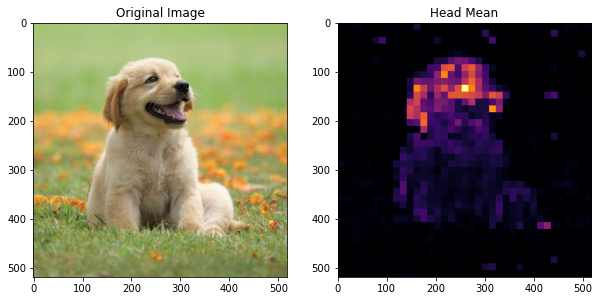

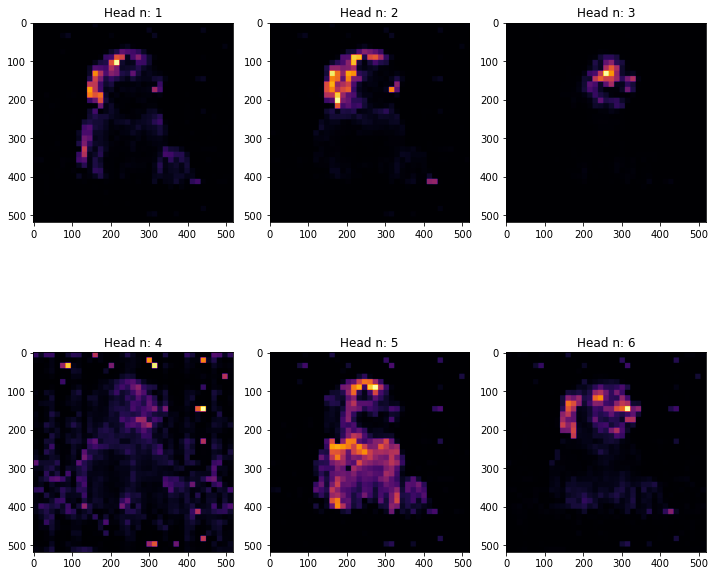

In [12]:
img = Image.open(image_path)
img = img.resize((image_size, image_size))

plot_attention(img, attentions)